# Lesson on Master Equation and Montecarlo Simulations

In [66]:
import numpy as np
import pylab as plt
import random as rn

In [67]:
#proportional destruction
def removal(state):
    return state*0.1

#Constant creation 
def increase(state):
    return 1

transitions = [removal, increase]
transitions_names = ['removal', 'increase']

We expect a Poisson distribution ??? with an average 10????

We define the initial state. We only need its current value we do not care of its history. Markovian system.

In [68]:
state = 5

I evalue the rates for the different porcesses

In [69]:
# I can fill a list with the output of a 
#list of function with the same input
rates = [f(state) for f in transitions]
rates

[0.5, 1]

In [70]:
total_rate = sum(rates)
total_rate

1.5

In [71]:
time = np.random.exponential(1/total_rate) #numpy asks for the scale parameter so we need to invert it
time

2.7341067911868624

In this way I get how much time I spend in the state. But I lost information about which proces I went through.
In order to decide which proces execute we choice randomly between them using the rates as weights.

In [72]:
rn.choices(transitions_names, weights=rates)

['increase']

Choices always return a list-form output. We can extraxt the first element in order to get the effective process.

In [73]:
event = rn.choices(transitions_names, weights=rates)[0]
print(event)

increase


Now we got to update the state of the system

In [74]:
if event == 'increase':
    state += 1
elif event == 'removal':
    state -= 1
else:
    raise ValueError("transition not recognized")

This is a rough version, but it works well for us and for now. We could complicate as we want this updating inserting any type of random effects.

In order to create the complete simulation we need to take track of which proces happened and when, we also need to decide when to stop this simulation.

In [75]:
#To make it nicer we import these two modules
#Make the code easier
import typing
from enum import Enum

In [76]:
class Transition(Enum):
    INCREASE = 'increase'
    DECREASE = 'removal'

class Observation(typing.NamedTuple):
    state: typing.Any
    time_of_observation: float
    time_of_residency: float
    transition: Transition

Observation allow us to have a nicer interface.

Why we ask that transition is a `Transition` object and then we pass a string????

In [77]:
Observation(5, 0.1, 0.33, Transition.DECREASE)

Observation(state=5, time_of_observation=0.1, time_of_residency=0.33, transition=<Transition.DECREASE: 'removal'>)

In [78]:
transitions = [removal, increase] #list of function
transitions_names = [Transition.DECREASE, Transition.INCREASE] #list of strings

### Simulation:

In [79]:
#Set up all the environment 
observed_states = []
state = 5
total_time = 0.0
time_limit = 5.0

#simulation loop:
while total_time < time_limit:
    rates = [f(state) for f in transitions] #Rates are updated according to the state every step
    total_rate = sum(rates)
    time = np.random.exponential(1/total_rate)#Extract the residence time
    event = rn.choices(transitions_names, weights=rates)[0]#Extract which process will happen
    
    observation = Observation(state, total_time, time, event)
    print(observation)
    observed_states.append(observation)
    
    total_time += time
    
    if event == Transition.INCREASE:
        state += 1
    elif event == Transition.DECREASE:
        state -= 1
    else:
        raise ValueError("transition not recognized")

Observation(state=5, time_of_observation=0.0, time_of_residency=1.4921335143540664, transition=<Transition.INCREASE: 'increase'>)
Observation(state=6, time_of_observation=1.4921335143540664, time_of_residency=0.14150989252387497, transition=<Transition.INCREASE: 'increase'>)
Observation(state=7, time_of_observation=1.6336434068779413, time_of_residency=0.8824643725755924, transition=<Transition.DECREASE: 'removal'>)
Observation(state=6, time_of_observation=2.5161077794535336, time_of_residency=0.08611816569428662, transition=<Transition.INCREASE: 'increase'>)
Observation(state=7, time_of_observation=2.6022259451478202, time_of_residency=0.9209176445690704, transition=<Transition.DECREASE: 'removal'>)
Observation(state=6, time_of_observation=3.5231435897168906, time_of_residency=0.634916843352778, transition=<Transition.INCREASE: 'increase'>)
Observation(state=7, time_of_observation=4.158060433069669, time_of_residency=0.4945181842731587, transition=<Transition.INCREASE: 'increase'>)
Ob

We can transform the simulation in a function  that returns the list of events:

In [80]:
def simulation(starting_state, time_limit):
    observed_states = []
    state = starting_state
    total_time = 0.0

    while total_time < time_limit:
        rates = [f(state) for f in transitions]
        total_rate = sum(rates)
        time = np.random.exponential(1/total_rate)
        event = rn.choices(transitions_names, weights=rates)[0]

        observation = Observation(state, total_time, time, event)
        observed_states.append(observation)

        total_time += time

        if event == Transition.INCREASE:
            state += 1
        elif event == Transition.DECREASE:
            state -= 1
        else:
            raise ValueError("transition not recognized")
    return observed_states

In [81]:
time_limit = 100
result = simulation(starting_state=5, time_limit=time_limit)

In [82]:
len(result)

187

In order to make a  more precise simulation I should consider that the `Time_limit` is overshoot by a little bit.

If we want to make an ECDF we need to count how wuch time the system visited each state.

In [83]:
from collections import Counter

In [84]:
Counter?

In [85]:
distribution = Counter()
for observation in result:
    state = observation.state
    residency_time = observation.time_of_residency
    distribution[state] += residency_time/time_limit
print(distribution)

Counter({9: 0.23451386883363146, 10: 0.2215002453514003, 8: 0.15825862392990578, 11: 0.13750365798070682, 12: 0.07637152504336502, 13: 0.05907734805609844, 6: 0.0544514617358841, 7: 0.04518273217003348, 5: 0.00989428123033831, 14: 0.0038376795642769863})


More correctly I should sum up all the residency times

In [86]:
import scipy.stats as st

<BarContainer object of 20 artists>

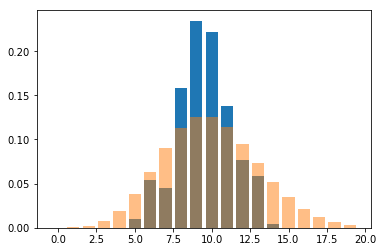

In [87]:
fig, ax = plt.subplots()
ax.bar(distribution.keys(), distribution.values())

values = np.arange(20)
pmf = st.poisson(10).pmf(values)
ax.bar(values, pmf, alpha=0.5)

We need a lot more of numbers to have a good cinvergence!

In [88]:
def generate_distribution(observation_sequence):
    distribution = Counter()
    for observation in observation_sequence:
        state = observation.state
        residency_time = observation.time_of_residency
        distribution[state] += residency_time
    total_time_observed = sum(distribution.values())
    for state in distribution:
        distribution[state] /= total_time_observed #This is the right way
    return distribution

In [89]:
time_limit = 1_000
result = simulation(starting_state=5, time_limit=time_limit)
distribution = generate_distribution(result)

Running the simulation for a longer time the convergence is far better

<BarContainer object of 20 artists>

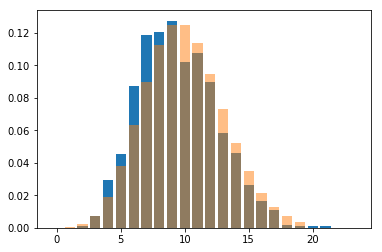

In [90]:
fig, ax = plt.subplots()
ax.bar(distribution.keys(), distribution.values())

values = np.arange(20)
pmf = st.poisson(10).pmf(values)
ax.bar(values, pmf, alpha=0.5)

I should evaluate how the maximum square difference between the two cdf decrease over the increasing in number of tries. If it goes to zero it's good.

### Warn in period

In [91]:
time_limit = 1_000
result = simulation(starting_state=50, time_limit=time_limit)
distribution = generate_distribution(result)

<BarContainer object of 20 artists>

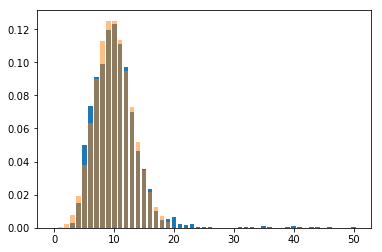

In [92]:
fig, ax = plt.subplots()
ax.bar(distribution.keys(), distribution.values())

values = np.arange(20)
pmf = st.poisson(10).pmf(values)
ax.bar(values, pmf, alpha=0.5)

The distribution has become very skewed! because the starting state is way to high.

In [93]:
time_limit = 1_000
result_1 = simulation(starting_state=50, time_limit=time_limit)
result_2 = simulation(starting_state=50, time_limit=time_limit)
result_3 = simulation(starting_state=50, time_limit=time_limit)

In [94]:
def plot_observations(observation_sequence, ax=None):
    if ax is None:
        ax = plt.gca()
    values = [obs.state for obs in observation_sequence]
    times = [obs.time_of_observation for obs in observation_sequence]
    ax.plot(times, values, linestyle='steps-post')

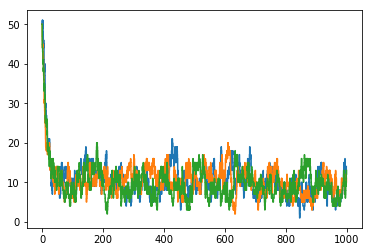

In [95]:
fig, ax = plt.subplots()
plot_observations(result_1)
plot_observations(result_2)
plot_observations(result_3)

We see that we could drop the very first part of the simulation, that represents a drift phase in the evolution of the system

## Absorbing states

an absorbing state is one where the transition rates for all the possible transitions is equal to zero.

When this happens, the expected residency time becomes infinite (the system is stuck there)

let's rewrite our functions so that 0 is an absorbing state

In [96]:
class Transition(Enum):
    INCREASE = 'increase'
    DECREASE = 'removal'
    ABSORPION = 'absorbed'

In [97]:
def removal_absorbing(state):
    return state*0.5

def increase_absorbing(state):
    return 1 if state>0 else 0

transitions = [removal_absorbing, increase_absorbing]
transitions_names = [Transition.DECREASE, Transition.INCREASE]

In [98]:
state = 0

In [99]:
rates = [f(state) for f in transitions]
rates

[0.0, 0]

In [100]:
total_rate = sum(rates)
total_rate

0.0

The residency time __diverges__!!

In [101]:
time = np.random.exponential(1/total_rate)
time

ZeroDivisionError: float division by zero

This is the way to manage correctly the divergence

In [ ]:
if total_rate>0:
    time = np.random.exponential(1/total_rate)
else:
    time = np.inf
time

In [ ]:
def simulation(starting_state, time_limit, transitions, transitions_names):
    observed_states = []
    state = starting_state
    total_time = 0.0

    while total_time < time_limit:
        rates = [f(state) for f in transitions]
        total_rate = sum(rates)
        if total_rate>0:
            time = np.random.exponential(1/total_rate)
            event = rn.choices(transitions_names, weights=rates)[0]
        else:
            time = np.inf
            event = Transition.ABSORPION
            
        observation = Observation(state, total_time, time, event)
        observed_states.append(observation)

        total_time += time

        if event == Transition.INCREASE:
            state += 1
        elif event == Transition.DECREASE:
            state -= 1
        elif event == Transition.ABSORPION:
            pass
        else:
            raise ValueError("transition not recognized")
    return observed_states

In [ ]:
result = simulation(5, time_limit=100,
                    transitions=[removal_absorbing, increase_absorbing],
                    transitions_names=[Transition.DECREASE, Transition.INCREASE])

In [ ]:
for observation in result:
    print(observation)
    print()

## Fixed time events

## [...]

## Exercise

there are still many things that can be done to implement this simulator:

1. allow the user to specify the effect of the various transitions
2. return the simulation not as a list, but as a dedicated objct that can :
    * be sliced over time: my_simulation[0.5:100.0]
    * have a plot function dedicated
    * automatically estimate the distribution
3. always include multiple runs of the simulation, an djoin this with point 2



There is a site [reference for slicing](https://www.pythoncentral.io/how-to-slice-custom-objects-classes-in-python/) custom objects

### This is a sliceable version of a Dictionaty
It rounds all about an editing of the `__getitem__` method.

In [ ]:
from collections.abc import Sequence
class MyDictStructure(Sequence):
    def __init__(self):
        self.data = {}
 
    def __len__(self):
        return len(self.data)
 
    def append(self, item):
        self.data[len(self)] = item
 
    def remove(self, item):
        if item in self.data.values():
            del self.data[item]
 
    def __repr__(self):
        return str(self.data)
 
    def __getitem__(self, sliced):
        print(sliced)
        slicedkeys = list(self.data.keys())[sliced]
        data = {k: self.data[k] for k in slicedkeys}        
        return data

In [ ]:
m = MyDictStructure()
m.append('First element')
m.append('Second element')
m.append('Third element')
m

In [ ]:
m[1:3]

In [142]:
from collections.abc import Sequence
class Sliceable_simulation(Sequence):
    def __init__(self):
        self.simulation = {}
 
    def __len__(self):
        return len(self.data)
 
    def append(self, item):
        self.simulation[len(self)] = item
 
    def remove(self, item):
        if item in self.simulation.values():
            del self.simulation[item]
 
    def __repr__(self):
        return str(self.simulation)
 
    def __getitem__(self, sliced):
        print(sliced)
        slicedkeys = list(self.simulation.keys())[sliced]
        simulation = {k: self.simulation[k] for k in slicedkeys}        
        return simulation
    
    def update(self, dic = {}):
        self.simulation.update(dic)
    
    def items(self):
        return self.simulation.items()

In [143]:
sim1 = Sliceable_simulation()
dic1={-1.0 : 'ciao'}
sim1.update(dic1)

In [144]:
fake_times= np.linspace(0,1,2**7+1)
fake_strings = ['ciao' for _ in range(1000)]
dic2 = {k: v for k,v in zip(fake_times, fake_strings) }

In [145]:
sim1.update(dic2)

In [146]:
def simulation(starting_state, time_limit, transitions, transitions_names):
    observed_states = Sliceable_simulation()
    state = starting_state
    total_time = 0.0

    while total_time < time_limit:
        rates = [f(state) for f in transitions]
        total_rate = sum(rates)
        if total_rate>0:
            time = np.random.exponential(1/total_rate)
            event = rn.choices(transitions_names, weights=rates)[0]
        else:
            time = np.inf
            event = Transition.ABSORPION
            
        observation = Observation(state, total_time, time, event)
        observed_states.update({total_time : observation})

        total_time += time

        if event == Transition.INCREASE:
            state += 1
        elif event == Transition.DECREASE:
            state -= 1
        elif event == Transition.ABSORPION:
            pass
        else:
            raise ValueError("transition not recognized")
    return observed_states

In [147]:
result = simulation(5, time_limit=100,
                    transitions=[removal_absorbing, increase_absorbing],
                    transitions_names=[Transition.DECREASE, Transition.INCREASE])

In [148]:
for k,v in result.items():
    print(k)
    print(v)

0.0
Observation(state=5, time_of_observation=0.0, time_of_residency=0.01940516847112916, transition=<Transition.INCREASE: 'increase'>)
0.01940516847112916
Observation(state=6, time_of_observation=0.01940516847112916, time_of_residency=0.8256955078121384, transition=<Transition.DECREASE: 'removal'>)
0.8451006762832676
Observation(state=5, time_of_observation=0.8451006762832676, time_of_residency=0.09683812150671052, transition=<Transition.DECREASE: 'removal'>)
0.9419387977899781
Observation(state=4, time_of_observation=0.9419387977899781, time_of_residency=0.2747762569629815, transition=<Transition.DECREASE: 'removal'>)
1.2167150547529597
Observation(state=3, time_of_observation=1.2167150547529597, time_of_residency=1.1924935908690089, transition=<Transition.DECREASE: 'removal'>)
2.409208645621969
Observation(state=2, time_of_observation=2.409208645621969, time_of_residency=0.2663904398821048, transition=<Transition.INCREASE: 'increase'>)
2.6755990855040737
Observation(state=3, time_of_